# COVID-19: Corona infections in Germany (by state)
based on numbers of the RKI (Robert Koch-Institut)

In [297]:
!pip install pyquery

In [330]:
from IPython.core.display import display, HTML

import re
import pandas as pd

from datetime import datetime
from datetime import date, timedelta
from dateutil import parser

from pyquery import PyQuery as pq
from lxml import etree
import urllib

## Gather data
No historical data is provided, so we'll get it with the help of the Wayback Machine 

In [299]:
# Gather URLs as data source for every relevant day

sdate = date(2020, 3, 1)  
edate = datetime.today().date()  

urls = []

for i in range((edate - sdate).days + 1):
    day = sdate + timedelta(days=i)
    day_str = day.strftime("%Y%m%d")
    urls.append(f"https://web.archive.org/web/{day_str}/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html")
    
# Let's be extra sure we also got the latest numbers:
urls.append('https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html')

urls

['https://web.archive.org/web/20200301/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200302/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200303/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200304/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200305/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200306/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200307/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200308/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200309/https://www.rki.d

In [300]:
tables = {}

for url in urls:
    d = pq(url=url)
    
    date_str = re.search(r"Stand: ?([0-9]{1,2}\.[0-9]{1,2}\.[0-9]{2,4})", d('p:contains("Stand:")').eq(0).text()).group(1)
    date_norm = parser.parse(date_str, dayfirst=True).strftime("%Y-%m-%d")
    
    element = d('#main table')
    tables[date_norm] = element
    
    # display(HTML(element.outerHtml()))

In [317]:
display(HTML(tables['2020-03-17'].outerHtml()))

In [381]:
# Normalize the different table visualizations and get them into a single DF
# Unfortunately the RKI does not stick to a single table format but keeps changing it every few days
# That's why this unification is getting a little bit messy now

dfa = pd.DataFrame()

for date, table in tables.items():
    html = table.outerHtml().replace('<th class="center" colspan="4" rowspan="1">Elektronisch übermittelte Fälle</th><th colspan="1" rowspan="1">Beson­ders be­trof­fene Gebiete in Deutsch­land</th></tr><tr><th colspan="1" rowspan="1"></th>', '')
    
    df = pd.DataFrame()
    df = pd.read_html(html, index_col=0, header=0, match="Bundesland", thousands=".")[0]
    df = df[:-1] # Remove last (summary) row
    
    # Remove potential lefovers from dropping the "betroffene Gebiete" column 
    df.drop(df.filter(regex="Unnamed"), axis=1, inplace=True)

    ### Column cleanup and normalization

    # Remove hidden characters in column names
    df.columns = map(lambda x: x.replace('\xad', ''), df.columns) 

    # Unify column names as they changed over time
    df.rename(columns={"Anzahl": "Fälle"}, inplace=True)

    # Drop non-relevant cols
    drop_cols = list(filter(re.compile(r'.*(Gebiete|übermittelt|Differenz|100\.000 Einw\.).*').search, df.columns))
    df.drop(columns=drop_cols, inplace=True)

    # Normalize format
    # Some tables have a dedicated column for deaths, some use paranthesis
    mixed_col = list(filter(re.compile(r'.*(darunter Todesfälle).*').search, df.columns))
    if(len(mixed_col) > 0):
        df = df[mixed_col[0]].replace(to_replace='\.', value='', regex=True).str.extract(r'(?P<Fälle>[0-9]+(?:\.[0-9]+)?)(?: ?\((?P<Todesfälle>[0-9]+)\))?').fillna(0).astype(int)

    df['date'] = date
    dfa = pd.concat([dfa, df])
    
display(dfa.head(5), dfa.tail(5))

,Fälle,date,Todesfälle
Bundesland,,,
Baden-Württemberg,15,2020-03-01,NaN
Bayern,23,2020-03-01,NaN
Bremen,1,2020-03-01,NaN
Hamburg,1,2020-03-01,NaN
Hessen,8,2020-03-01,NaN


,Fälle,date,Todesfälle
Bundesland,,,
Saarland,88,2020-03-18,0.0
Sachsen,198,2020-03-18,0.0
Sachsen-Anhalt,105,2020-03-18,0.0
Schleswig-Holstein,159,2020-03-18,0.0
Thüringen,74,2020-03-18,0.0


## Reshuffling for plotting

In [382]:
dfa['date'] = pd.to_datetime(dfa['date'], infer_datetime_format=True)

In [383]:
confirmed = dfa.reset_index().pivot(index='date', columns='Bundesland', values='Fälle').fillna(0)
deaths = dfa.reset_index().pivot(index='date', columns='Bundesland', values='Todesfälle').fillna(0)

# Sorting
confirmed = confirmed.loc[:, confirmed.max().sort_values(ascending=False).index]
deaths = deaths.loc[:, deaths.max().sort_values(ascending=False).index]

display(confirmed.tail(3))
display(deaths.tail(3))

Bundesland,Nordrhein-Westfalen,Baden-Württemberg,Bayern,Niedersachsen,Rheinland-Pfalz,Hessen,Berlin,Hamburg,Sachsen,Schleswig-Holstein,Sachsen-Anhalt,Brandenburg,Saarland,Thüringen,Bremen,Mecklenburg-Vorpommern,Schleswig Holstein,Repatriierte
date,,,,,,,,,,,,,,,,,,
2020-03-15,1407.0,827.0,886.0,287.0,168.0,286.0,265.0,162.0,130.0,103.0,47.0,84.0,32.0,51.0,53.0,50.0,0.0,0.0
2020-03-17,2105.0,1479.0,1109.0,325.0,442.0,373.0,345.0,310.0,182.0,127.0,58.0,73.0,75.0,51.0,57.0,45.0,0.0,0.0
2020-03-18,2372.0,1609.0,1243.0,478.0,474.0,432.0,391.0,358.0,198.0,159.0,105.0,92.0,88.0,74.0,69.0,56.0,0.0,0.0


Bundesland,Nordrhein-Westfalen,Bayern,Baden-Württemberg,Mecklenburg-Vorpommern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Thüringen,Schleswig-Holstein,Repatriierte,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig Holstein,Niedersachsen
date,,,,,,,,,,,,,,,,,,
2020-03-15,5.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-17,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-18,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [384]:
print(f"Total confirmed cases in Germany: {confirmed[-1:].sum(axis=1)[0]}")
print(f"Total confirmed deaths in Germany: {deaths[-1:].sum(axis=1)[0]}")

Total confirmed cases in Germany: 8198.0
Total confirmed deaths in Germany: 12.0


## Time series of infections per state since March

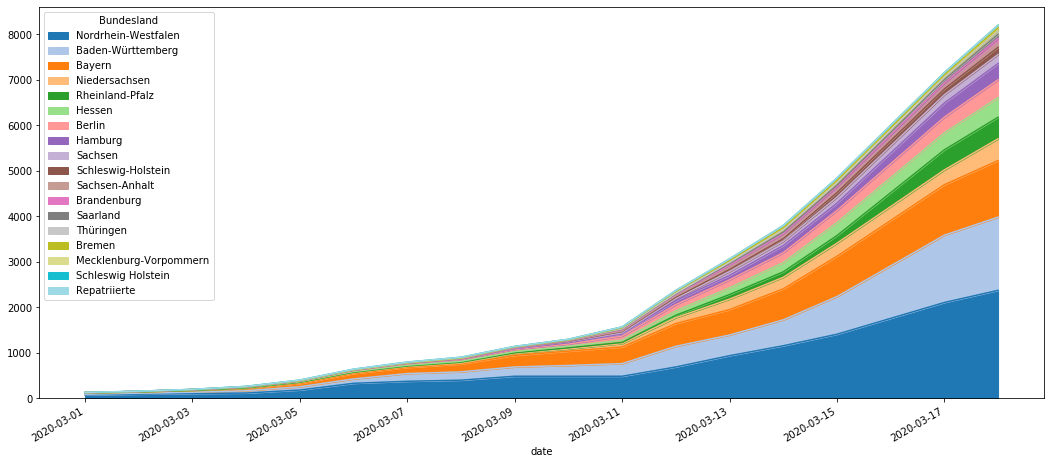

In [400]:
plot1 = confirmed.plot(figsize=(18,8), kind='area', cmap="tab20")

In [401]:
plot1.get_figure().savefig("images/area_chart_infections_germany_by_state.png")

# Northern Germany

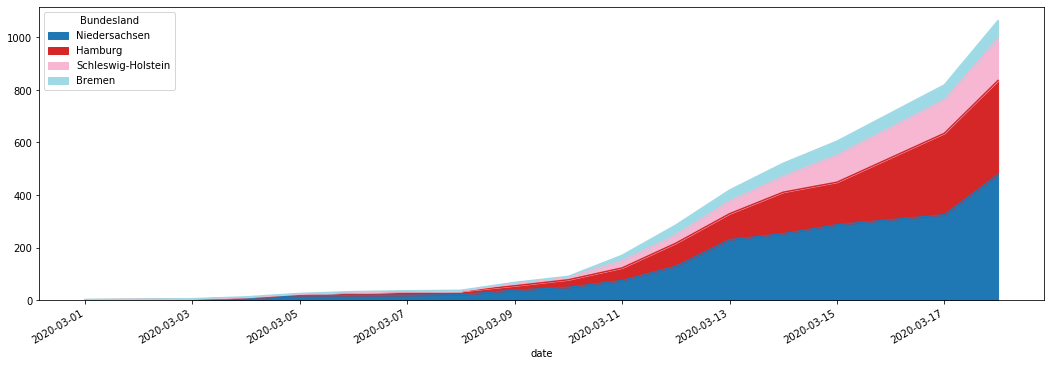

In [402]:
plot2 = confirmed[['Niedersachsen','Hamburg','Schleswig-Holstein','Bremen']].plot(figsize=(18,6), kind='area', cmap="tab20")

In [403]:
plot2.get_figure().savefig("images/area_chart_infections_germany_northern_germany.png")

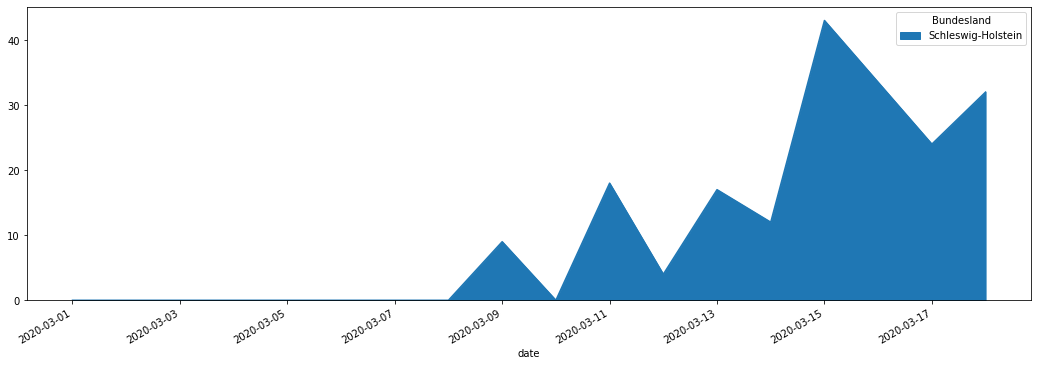

In [404]:
plot3 = confirmed[['Schleswig-Holstein']].diff().plot(figsize=(18,6), kind='area', cmap="tab20")

## Daily increases last 4 days

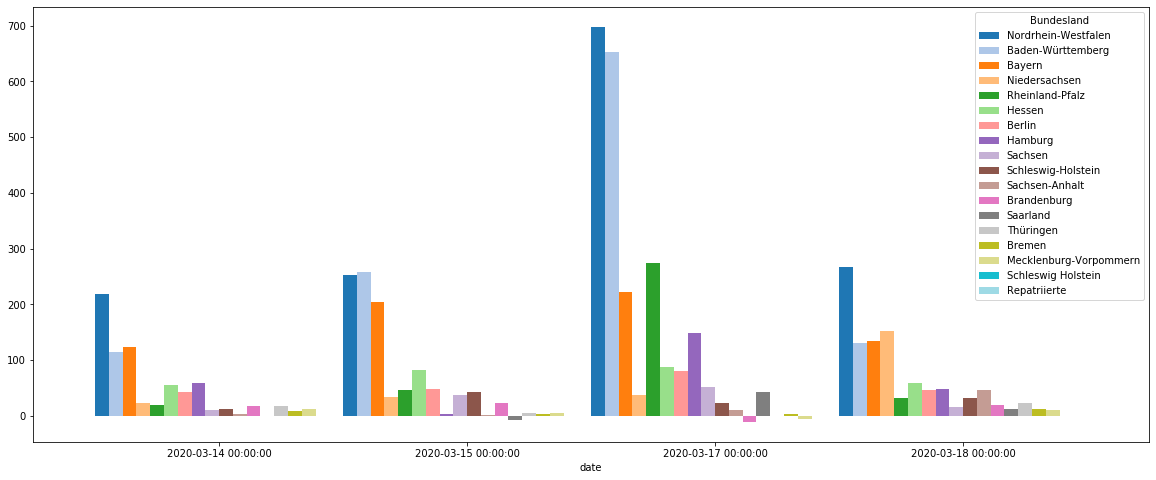

In [405]:
df_diff = confirmed.diff().tail(4)
plot4 = df_diff.plot(figsize=(20,8), cmap="tab20",  kind="bar", align='center', width=1.0, rot=0)

In [406]:
plot4.get_figure().savefig("images/area_chart_dailydiffs_germany_by_state.png")

## Simple forecast 

In [407]:
confirmed.sum(axis=1)

date
2020-03-01     129.0
2020-03-02     157.0
2020-03-03     196.0
2020-03-04     262.0
2020-03-05     400.0
2020-03-06     639.0
2020-03-07     795.0
2020-03-08     902.0
2020-03-09    1139.0
2020-03-10    1296.0
2020-03-11    1567.0
2020-03-12    2369.0
2020-03-13    3062.0
2020-03-14    3795.0
2020-03-15    4838.0
2020-03-17    7156.0
2020-03-18    8198.0
dtype: float64

In [408]:
import matplotlib.dates as mdates

dates = list(confirmed.index)
x = mdates.date2num(dates)
y = list(map(int, (confirmed.sum(axis=1))))

/Users/bjoern.baltbardis/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


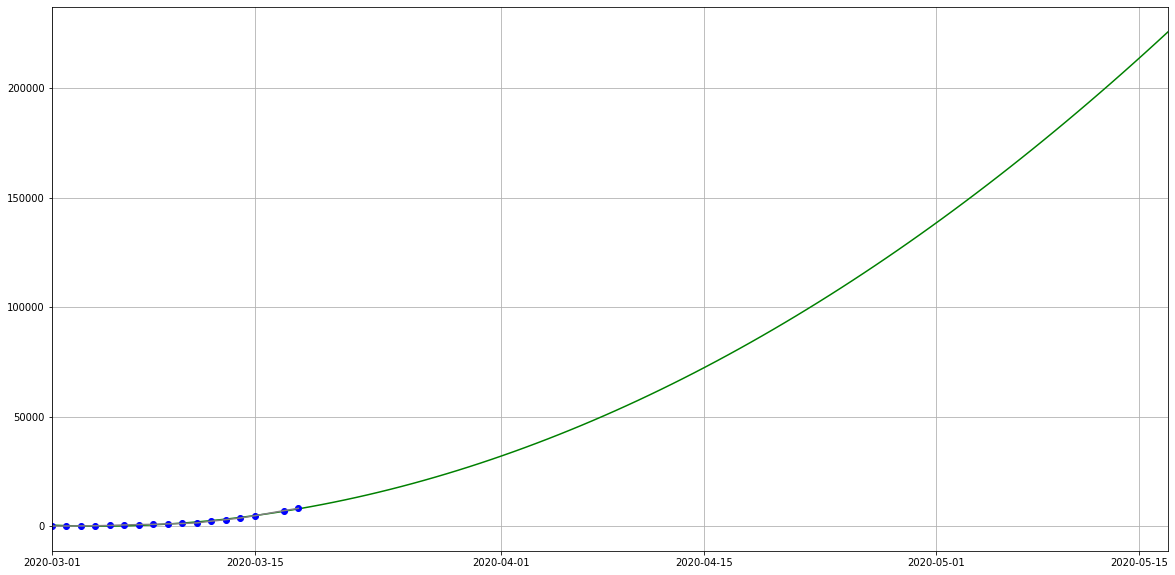

In [409]:
import numpy as np
import matplotlib.pyplot as plt

predict_days = 60

z4 = np.polyfit(x, y, 4)
p4 = np.poly1d(z4)

fig, cx = plt.subplots(figsize=(20,10))

xx = np.linspace(x.min(), x.max() + predict_days, 100)

cx.plot(mdates.num2date(xx), p4(xx), '-g')
cx.plot(dates, y, 'o', color='b', label='blub')
cx.plot(dates, y, color='gray')

cx.set_xlim(x[0], x[len(x)-1]+predict_days)
cx.grid()

plt.show()
fig.savefig(f"images/forecast_{predict_days}_days.png")